# "image_top_1" Completion by learning - Classification

Due to the importance of the image_top_1 feature (and the price) in LGBM's ratings, we wish to complete them in a "smart" way (not just 0 mode/median or NA). In this notebook we learn image_top_1 from other (non-image) features of our data by training a classification NN.

In [1]:
%load_ext autoreload

In [2]:
%run stephan_modules.ipynb

/glob/intel-python/versions/2018/intelpython3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

Using TensorFlow backend.


In [3]:
DATA_PATH = '/home/u14303/Avito'
HELPER_DATA_PATH = '/home/u14303/Avito/helper_data'

## Feature enrichment

Load all engineered features.

In [4]:
print('loading data...')
train, test = load_data(DATA_PATH)
train, test = basic_enrichment(train, test, helper_data_path=HELPER_DATA_PATH)
train, test = load_image_features(train, test, helper_data_path=HELPER_DATA_PATH)
train, test = load_text_features(train, test, helper_data_path=HELPER_DATA_PATH)
train, test = add_aggregated_features(train, test, helper_data_path=HELPER_DATA_PATH)
train, test = numeric_features_cleaning(train, test, helper_data_path=HELPER_DATA_PATH)

loading data...
Adding basic features...
Done adding basic features.
Adding image features...


/home/u14303/stephan_feature_enrichment.py:65: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/u14303/stephan_feature_enrichment.py:66: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Done loading image features.
Loading text features...
Done loading text features.
Loading aggregated features...
Done loading aggregated features.
Loading aggregated features...
Done loading aggregated features.
Cleaning and completing numeric features...


/home/u14303/stephan_feature_enrichment.py:172: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/u14303/stephan_feature_enrichment.py:173: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Done cleaning numeric features.


In [5]:
list(train.columns)

['item_id',
 'user_id',
 'region',
 'city',
 'parent_category_name',
 'category_name',
 'param_1',
 'param_2',
 'param_3',
 'title',
 'description',
 'price',
 'item_seq_number',
 'activation_date',
 'user_type',
 'image',
 'image_top_1',
 'deal_probability',
 'has_description',
 'has_price',
 'has_params',
 'has_image',
 'month',
 'day',
 'weekday',
 'user_ads_count',
 'title_description_params',
 'img_size',
 'img_sharpness',
 'img_luminance',
 'img_colorfulness',
 'img_confidence',
 'img_keypoints',
 'log_img_sharpness',
 'log_img_keypoints',
 'title_word_count',
 'description_non_regular_chars_ratio',
 'description_word_count',
 'merged_params_word_count',
 'description_sentence_count',
 'description_words/sentence_ratio',
 'title_capital_letters_ratio',
 'description_capital_letters_ratio',
 'title_non_regular_chars_ratio',
 'title_num_of_newrow_char',
 'description_num_of_newrow_char',
 'title_num_adj',
 'title_num_nouns',
 'title_adj_to_len_ratio',
 'title_noun_to_len_ratio',
 '

Keep real item (ad) IDs for later merge and save.

In [6]:
r_train_ids = pd.DataFrame(train['item_id'])
r_test_ids = pd.DataFrame(test['item_id'])

Turn the train dataframe to contain all samples we have 'image_top_1' labels for (from original test and train dataframes). Respectively put all samples that we do not have 'image_top_1' labels for in "test" dataframe.

In [7]:
train = pd.concat([train, test], axis = 0)

/glob/intel-python/versions/2018/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




In [8]:
test = train[train['image_top_1'].isna()]

In [9]:
train = train[train['image_top_1'].isna() == False]

#### image_top_1
image_top_1 seems to be a continious number.

In [10]:
cat_number = train['image_top_1'].nunique()
cat_number

3063

But really its some kind of an ordinal class. We try to learn it as if it was a class label.

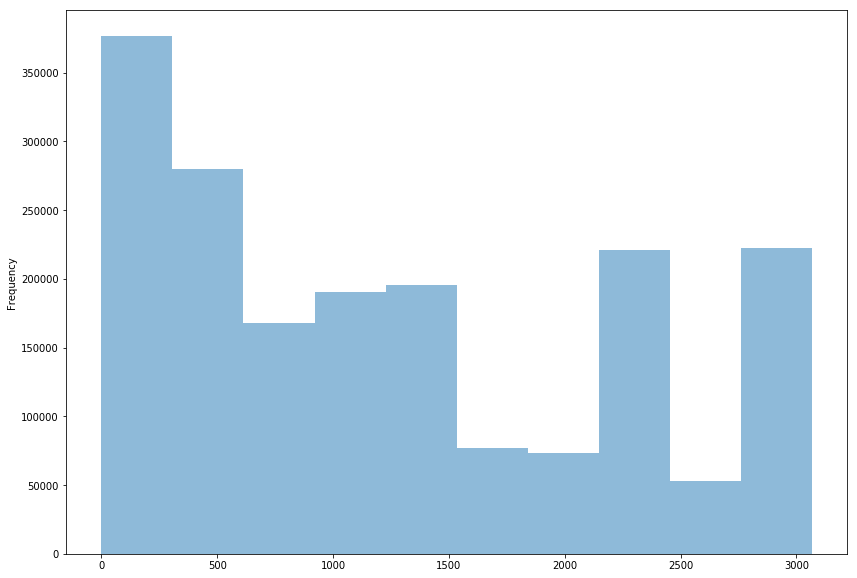

In [11]:
train['image_top_1'].plot.hist(alpha=0.5)

In [12]:
from keras.utils import np_utils

# encode image_top_one into integer class values
labelenc = LabelEncoder()
y_target = train['image_top_1']
labelenc.fit(y_target)
image_top_1_labels = labelenc.transform(train['image_top_1'])
image_top_1_onehot = np_utils.to_categorical(image_top_1_labels)

## Vectorize features towards input to an NN

Pick features to feed into the NN that will be used to learn 'image_top_1' in a "classification" method. Pay attention that we exclude image features as for samples with missing image_top_1s, there is no images (and thus no image features).

In [13]:
text_feature = 'title_description_params'
cat_features = ['user_type', \
                'region', 'city', \
                'parent_category_name', 'category_name', 'param_1', 'param_2', 'param_3', \
                'month', 'day', 'weekday', \
                'has_description', 'has_price', 'has_params']
cont_ord_features = ['avg_days_up_user', 'avg_times_up_user', 'n_user_items', 'user_ads_count', \
                     'log_price', 'log_item_seq_number', \
                     'title_word_count', 'description_word_count', 'merged_params_word_count', \
                     'description_non_regular_chars_ratio', 'title_capital_letters_ratio','description_capital_letters_ratio', \
                     'title_non_regular_chars_ratio', 'title_adj_to_len_ratio', 'title_noun_to_len_ratio',\
                     'title_sentiment']

#### Text features

TF-IDF vectorize merged texts

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

text_tfidf_dim = 7500

train_x_text = train[text_feature].astype('str')
test_x_text = test[text_feature].astype('str')
all_text = np.hstack([train_x_text, test_x_text])

tfidf_enc = TfidfVectorizer(max_features=text_tfidf_dim, ngram_range=(1, 1), dtype=np.float32)
print('Fitting tf-idf on text...')
tfidf_enc.fit(all_text)
print('Done.')

del all_text
gc.collect()

Fitting tf-idf on text...
Done.


33

In [15]:
print('TF-IDF: applying encoder on text...')

train_x_text = tfidf_enc.transform(train_x_text)
test_x_text = tfidf_enc.transform(test_x_text)

print('Done.')

TF-IDF: applying encoder on text...
Done.


#### Categorical features.

Vectorize all loaded categorical features.


See: http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html

In [16]:
train_x_cat = train[cat_features]
test_x_cat = test[cat_features]
for col in cat_features:
    train_x_cat[col] = train_x_cat[col].astype('category')
    test_x_cat[col] = test_x_cat[col].astype('category')

# Encode to integers.
# For vectorization (encoding) we concat both train and test into one
all_cat = pd.concat([train_x_cat, test_x_cat], axis = 0)
for col in cat_features:
    enc = preprocessing.LabelEncoder().fit(all_cat[col])
    train_x_cat[col] = enc.transform(train_x_cat[col])
    test_x_cat[col] = enc.transform(test_x_cat[col])

# One-hot encode:
enc = OneHotEncoder()
enc.fit(pd.concat([train_x_cat, test_x_cat], axis = 0))
train_x_cat = enc.transform(train_x_cat)
test_x_cat = enc.transform(test_x_cat)

del all_cat
gc.collect()

/glob/intel-python/versions/2018/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/glob/intel-python/versions/2018/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/glob/intel-python/versions/2018/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

70

#### Numerical(Continious/Ordinal) features

Normalize all loaded numeric features.

In [17]:
train_x_numerical = train[cont_ord_features]
test_x_numerical = test[cont_ord_features]
train_x_numerical.fillna(0, inplace = True)
test_x_numerical.fillna(0, inplace = True)
for col in cont_ord_features:
    train_x_numerical[col] = train_x_numerical[col].astype('float64')
    test_x_numerical[col] = test_x_numerical[col].astype('float64')

# Normalize features:
train_x_numerical = normalize(train_x_numerical, axis=0)
test_x_numerical = normalize(test_x_numerical, axis=0)

/home/u14303/.local/lib/python3.6/site-packages/pandas/core/frame.py:3790: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/glob/intel-python/versions/2018/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/glob/intel-python/versions/2018/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexi

# Learning - Neural Net

### Define network

In [18]:
text_hidden_dim = 256
cat_hidden_dim = 128
merged_hidden_dim = 256
out_dim = cat_number

In [19]:
#Text
l_text_input = Input(shape=(text_tfidf_dim,), sparse=True, name="text_tfidf_input")
l_hidden_text = Dense(text_hidden_dim, activation='relu', 
                      kernel_regularizer=regularizers.l2(1e-6), name='l_hidden_text')(l_text_input)

# Categoricals
l_cat_input = Input(shape=(train_x_cat.shape[1],), sparse=True, name="cat_input")
l_hidden_cat = Dense(cat_hidden_dim, activation='relu',
                     kernel_regularizer=regularizers.l2(1e-6), name='l_hidden_cat')(l_cat_input)

# Numerical
l_numerical_input = Input(shape=(train_x_numerical.shape[1],), name="numerical_input")

# Aggregate all inputs into one hidden layer.
l_aggregative = concatenate([l_hidden_text, l_hidden_cat, l_numerical_input])

l_merged_hidden = Dense(merged_hidden_dim, activation='relu',
                            kernel_regularizer=regularizers.l2(1e-6), name='l_merged_hidden')(l_aggregative)
output = Dense(out_dim, activation='softmax', name='output')(l_merged_hidden)

adam_opt = Adam(lr=0.001)
model = Model(inputs=[l_text_input, l_cat_input, l_numerical_input], outputs=[output])
model.compile(optimizer=adam_opt,
              loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_tfidf_input (InputLayer)   (None, 7500)         0                                            
__________________________________________________________________________________________________
cat_input (InputLayer)          (None, 3822)         0                                            
__________________________________________________________________________________________________
l_hidden_text (Dense)           (None, 256)          1920256     text_tfidf_input[0][0]           
__________________________________________________________________________________________________
l_hidden_cat (Dense)            (None, 128)          489344      cat_input[0][0]                  
__________________________________________________________________________________________________
numerical_

In [20]:
reduce_lr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, mode='min', min_delta=0.01,
                                  verbose=1, min_lr=0.0001)
nbatch_size = 512

# Train for iters*1 epochs. After each iteration enlarge batch size by factor 2 (we do this to prevent overfit).
iters = 2
for i in range(iters):
    print ('Current batch size: {}'.format(nbatch_size))
    model.fit({'text_tfidf_input': train_x_text, 'cat_input': train_x_cat, 'numerical_input': train_x_numerical},
              [image_top_1_onehot], 
              validation_split = 0.10, 
              epochs=1, 
              batch_size=nbatch_size, 
              callbacks=[reduce_lr_cb])
    nbatch_size *= 2

# Train on all data.
print ('Current batch size: {}'.format(nbatch_size))
model.fit({'text_tfidf_input': train_x_text, 'cat_input': train_x_cat, 'numerical_input': train_x_numerical},
              [image_top_1_onehot], 
              epochs=1, 
              batch_size=nbatch_size)

Current batch size: 512
Train on 1670998 samples, validate on 185667 samples
Epoch 1/1
1670998/1670998 [==============================] - 274s 164us/step - loss: 3.2320 - acc: 0.3679 - val_loss: 2.8256 - val_acc: 0.4181
Current batch size: 1024
Train on 1670998 samples, validate on 185667 samples
Epoch 1/1
1670998/1670998 [==============================] - 229s 137us/step - loss: 2.6948 - acc: 0.4322 - val_loss: 2.7455 - val_acc: 0.4303
Current batch size: 2048
Epoch 1/1
1856665/1856665 [==============================] - 227s 122us/step - loss: 2.6009 - acc: 0.4444


#### Complete missing image_top_1s and save

In [21]:
predictions = model.predict({'text_tfidf_input': test_x_text, 'cat_input': test_x_cat, 'numerical_input': test_x_numerical})

In [22]:
predicted_labels = np.argmax(predictions, axis=1)

In [23]:
image_top_1_predictions = labelenc.inverse_transform(predicted_labels)

/glob/intel-python/versions/2018/intelpython3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



In [24]:
res_test_df = pd.DataFrame(test['item_id'])
res_test_df['image_top_1_class'] = image_top_1_predictions

In [25]:
res_train_df = pd.DataFrame(train['item_id'])
res_train_df['image_top_1_class'] = y_target

Sanity check: compare between existing and learned image_top_1s (distribution wise)

In [26]:
res_train_df['image_top_1_class'].describe()

count    1.856665e+06
mean     1.255989e+03
std      9.684190e+02
min      0.000000e+00
25%      4.320000e+02
50%      1.092000e+03
75%      2.218000e+03
max      3.066000e+03
Name: image_top_1_class, dtype: float64

In [27]:
res_test_df['image_top_1_class'].describe()

count    155197.000000
mean       1872.631894
std         598.249096
min           0.000000
25%        1320.000000
50%        2195.000000
75%        2262.000000
max        3066.000000
Name: image_top_1_class, dtype: float64

In [28]:
print(res_train_df['image_top_1_class'].head(10))
print(res_train_df['image_top_1_class'].nunique())

0    1008.0
1     692.0
2    3032.0
3     796.0
4    2264.0
5     796.0
6    2823.0
7     567.0
8     415.0
9      46.0
Name: image_top_1_class, dtype: float64
3063


In [29]:
print(res_test_df['image_top_1_class'].head(10))
print(res_test_df['image_top_1_class'].nunique())

19    2262.0
21     334.0
32    2858.0
38    2218.0
55    2262.0
60    1308.0
68    2191.0
69    2214.0
74    2262.0
91    2218.0
Name: image_top_1_class, dtype: float64
1712


Looking good...

In [30]:
res_df = pd.concat([res_train_df, res_test_df], axis = 0)

In [31]:
r_train_ids = r_train_ids.merge(res_df, on='item_id', how='left')
r_test_ids = r_test_ids.merge(res_df, on='item_id', how='left')

In [32]:
r_train_ids.to_csv("/home/u14303/Avito/completed_train_image_top_1_class.csv.gz", compression='gzip', index=False)
r_test_ids.to_csv("/home/u14303/Avito/completed_test_image_top_1_class.csv.gz", compression='gzip', index=False)